In [7]:
import emcee
import numpy as np
import scipy
from astropy.io import fits
from astropy.table import Table
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.cosmology import Planck18 as cosmo
from functools import partial
import time

In [91]:
# Imports Catalog and creats a table (t_amas_match) containing Mass ('M'), redshift ('zp') and richness ('n200')


path_halo = '/sps/lsst/groups/clusters/cluster_comparison_project/after_matching/cosmoDC2_pywazp.DC2.tpz.T500k.pointEstimateMags/zband/proximity_matching/deltaz_0.03_matchradius_1.0mpc_pref_more_massive/cat1.fits'

path_amas = '/sps/lsst/groups/clusters/cluster_comparison_project/after_matching/cosmoDC2_pywazp.DC2.tpz.T500k.pointEstimateMags/zband/proximity_matching/deltaz_0.03_matchradius_1.0mpc_pref_more_massive/cat2.fits'

t = Table.read(path_amas)

def table(path):
    with fits.open(path) as hdul:
        table = Table(hdul[1].data)
    return table

t_halo = table(path_halo)
t_amas = table(path_amas)
t_amas_match = t_amas[t_amas["mt_cross"] !='']

M = []
for id in t_amas_match["mt_cross"]:
    ligne = t_halo[t_halo["halo_id"] == id]
    M.append(ligne["m200c"][0])
t_amas_match["M"] = M
t_amas_match = t_amas_match[t_amas_match["snr"]>6]

def tableau_coupure_n200(coupure):
    return t_amas_match[t_amas_match["n200"]>coupure]
def tableau_bin_n200(binn):
    a, b = binn
    return t_amas_match[(t_amas_match["n200"]>a) & (t_amas_match["n200"]<b)]

Mp, zp = 10**14.3, 0.5


In [202]:
# Returns a dict where res['params'] = (A, B, D, E)
# richesse_bin and redshift_bin must be tuples with 2 int or float elements each
def reg_lin_analysis(richesse_bin, redshift_bin):
    #Binage
    a, b = richesse_bin
    c, d = redshift_bin
    catalog = t_amas_match[(t_amas_match["n200"]>a) & (t_amas_match["n200"]<b) & (t_amas_match["zp"]>c) & (t_amas_match["zp"]<d)]

    print(len(catalog))
    
    #Bins dans catalog pour paramétrer std(M)
    list_bin_M = []   
    Mi = np.logspace(np.log10(min(catalog['M'])), np.log10(max(catalog['M'])), 4)
    for i in range(len(Mi)-1):
        list_bin_M.append(catalog[(catalog['M']>Mi[i])&(catalog['M']<Mi[i+1])])
    M_Mp_bin_milieu = np.array([0.5*(Mi[i+1]+Mi[i])/Mp for i in range(len(Mi)-1)])
    
    #Std sur ces bins
    list_std_bin = []
    for binage in list_bin_M:
        list_std_bin.append(np.std(np.log(binage['n200'])))
    
    #Régressions linéaires (affines)
    reg = np.polyfit(np.log(catalog['M']/Mp), np.log(catalog['n200']), 1)
    reg_std = np.polyfit(np.log(M_Mp_bin_milieu), list_std_bin, 1)

    A, B = reg[1], reg[0]
    D, E = reg_std[1], reg_std[0]

    # Generates datapoints according to the previous linear regressions
    L = []
    model_mean = lambda m, A, B: A+B*np.log(m/Mp)
    model_std = lambda m, D, E: D+E*np.log(m/Mp)
    for amas in catalog:
        m_ = amas['M']
        moy, std = model_mean(m_, A, B), model_std(m_, D, E)
        L.append(np.exp(np.random.normal(moy, std, 1)[0]))

    
    res = {}
    res['params'] = (A, B, D, E)    # Paramètres du modèle log-normal
    res['catalog'] = catalog        # Catalogue de binné en richesse et en redshift
    res['L_model'] = L              # Liste des richesse d'après le modèle déterminé ( L[i] <--> catalog['n200'][i] )
    res['std'] = list_std_bin       # Liste des std pour chaque bin de masse de catalog
    res['bins_M_std'] = M_Mp_bin_milieu  # Liste du centre des bins de masse de catalog
    
    return res

In [203]:
# Shows a scatter of the binned catalog used by reg_lin_analysis and plots the regression of the mean made by reg_lin_analysis over it.
def show_mean_reg(res, xscale = 'log', yscale = 'log', 
                          label_data = 'data', label_reg = 'Modèle paramétré', title = '', xlabel = r'$M/ M_p$', ylabel = r'$\lambda$',
                          data_color = 'b', reg_color = 'r', marker = '+'):

    if data_color == reg_color:
        print("WARNING : COLOR CHOICE MAY ALTER READABILITY")
    
    A, B, D, E = res['params']
    catalog = res['catalog']
    m = np.logspace(np.log10(min(catalog['M'])), np.log10(max(catalog['M'])), 10)
    model = lambda m, A, B: np.exp(A+B*np.log(m/Mp))
    plt.scatter(catalog["M"]/Mp, catalog["n200"],
                marker = marker, label = label_data, color = data_color)
    plt.plot(m/Mp, model(m, A, B),
             color = reg_color, label = label_reg)
    plt.title(title)
    plt.yscale(yscale)
    plt.xscale(xscale)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend()
    plt.grid()
    plt.show()

In [204]:
# shows a scatter of the std of each mass bin and plots the linear regression made by reg_lin_analysis
def show_std_reg(res, label_std = r'$\sigma(M/M_p)$', label_reg = 'Linear regression', title = '', xlabel = r'$ln(M/ M_p)$', ylabel = r'$\sigma$',
                          std_color = 'k', reg_color = 'r'):
    A, B, D, E = res['params']
    std_list = res['std']
    M_Mp_bin_milieu = res['bins_M_std']
    plt.scatter(np.log(M_Mp_bin_milieu), std_list, 
                color = std_color, label = label_std)
    plt.plot([np.log(M_Mp_bin_milieu[0]), np.log(M_Mp_bin_milieu[-1])], [E*np.log(M_Mp_bin_milieu[0])+D, E*np.log(M_Mp_bin_milieu[-1])+D], 
             color = reg_color, label = label_reg)
    plt.grid()
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend()
    plt.show()

In [205]:
# Shows 2 scatters : the binned catalog used by reg_lin_analysis and a distribution of clusters based on the regressions made by reg_lin_analysis.
# Plus, it shows the mean regression
def show_catalog_vs_model(res, xscale = 'log', yscale = 'log', 
                          label_data = 'data', label_model = 'model', label_reg = 'Modèle paramétré', title = '', xlabel = r'$\lambda$', ylabel = r'$\lambda$',
                          data_color = 'r', model_color = 'b', reg_color = 'r'):

    if data_color == model_color or model_color == reg_color:
        print("WARNING : COLOR CHOICE MAY ALTER READABILITY")
    
    A, B, D, E = res['params']
    catalog = res['catalog']
    L = res['L_model']
    
    m = np.logspace(np.log10(min(catalog['M'])), np.log10(max(catalog['M'])), 10)
    model = lambda m, A, B: np.exp(A+B*np.log(m/Mp))

    fig, ax = plt.subplots(1, 1, figsize=(15, 8), sharex=False, sharey=True)
    ax.set_title(title)
    ax.scatter(catalog["M"]/Mp, catalog["n200"], color = data_color, label = label_data)
    ax.scatter(catalog["M"]/Mp, L, color = model_color, label = label_model)
    ax.plot(m/Mp, model(m, A, B), color = reg_color, label = label_reg)
    ax.set_yscale(yscale)
    ax.set_xscale(xscale)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.legend()
    ax.grid()
    plt.show()

In [206]:
li = [20, 35, 70, 100]
zi = [0.2, 0.5, 0.8, 1.5]

In [207]:
list_bin_richesse = [(li[i], li[i+1]) for i in range(len(li)-1)]
list_bin_redshift = [(zi[i], zi[i+1]) for i in range(len(zi)-1)]
print(list_bin_richesse)
print(list_bin_redshift)

[(20, 35), (35, 70), (70, 100)]
[(0.2, 0.5), (0.5, 0.8), (0.8, 1.5)]


In [208]:
l_moyen = [0.5*(li[i]+li[i+1]) for i in range(len(li)-1)]
z_moyen = [0.5*(zi[i]+zi[i+1]) for i in range(len(zi)-1)]
print(l_moyen)
print(z_moyen)

[27.5, 52.5, 85.0]
[0.35, 0.65, 1.15]


In [209]:
mat_A = np.zeros((len(z_moyen), len(l_moyen)))
mat_B = np.zeros((len(z_moyen), len(l_moyen)))
mat_D = np.zeros((len(z_moyen), len(l_moyen)))
mat_E = np.zeros((len(z_moyen), len(l_moyen)))
print(mat_A)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [210]:
for bin_z in range(len(list_bin_redshift)):
    for bin_n200 in range(len(list_bin_richesse)):
        
        print(list_bin_richesse[bin_n200])
        print(list_bin_redshift[bin_z])
        print('\n')
        
        res = reg_lin_analysis(richesse_bin = list_bin_richesse[bin_n200], redshift_bin = list_bin_redshift[bin_z])
        A, B, D, E = res['params']
        mat_A[bin_z, bin_n200] = A
        mat_B[bin_z, bin_n200] = B
        mat_D[bin_z, bin_n200] = D
        mat_E[bin_z, bin_n200] = E

(20, 35)
(0.2, 0.5)


667
(35, 70)
(0.2, 0.5)


347
(70, 100)
(0.2, 0.5)


68
(20, 35)
(0.5, 0.8)


1429
(35, 70)
(0.5, 0.8)


625
(70, 100)
(0.5, 0.8)


84
(20, 35)
(0.8, 1.5)


3504
(35, 70)
(0.8, 1.5)


1072
(70, 100)
(0.8, 1.5)


110


In [211]:
len(t_amas_match[(t_amas_match['zp']>0.2)&(t_amas_match['zp']<1.5)&(t_amas_match['n200']>20)&(t_amas_match['n200']<100)])

7906

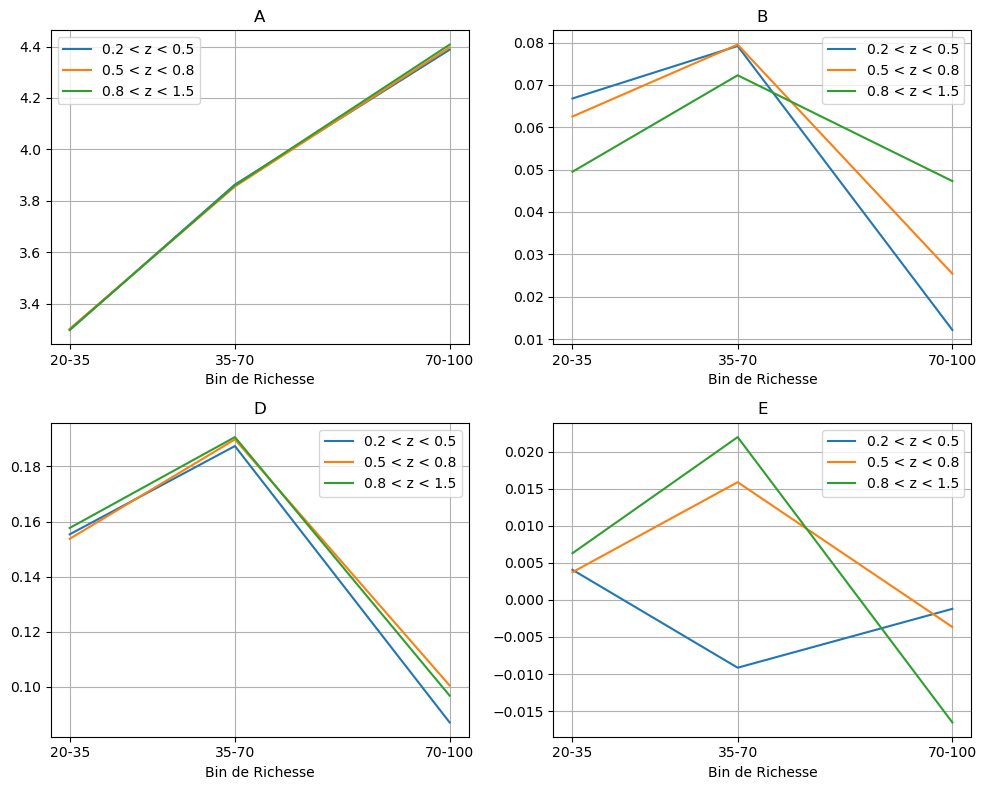

In [212]:
bin_labels = ['20-35', '35-70', '70-100']
fig, ax = plt.subplots(2, 2, figsize=(10, 8), sharex=False, sharey=False)
ax[0, 0].plot(l_moyen, mat_A[0], label = "0.2 < z < 0.5")
ax[0, 0].plot(l_moyen, mat_A[1], label = "0.5 < z < 0.8")
ax[0, 0].plot(l_moyen, mat_A[2], label = "0.8 < z < 1.5")
ax[0, 0].set_title('A')
ax[0, 0].set_xlabel('Bin de Richesse')
ax[0, 0].legend()
ax[0, 0].grid()
# Appliquer les labels personnalisés
ax[0, 0].set_xticks(l_moyen)
ax[0, 0].set_xticklabels(bin_labels)

ax[0, 1].plot(l_moyen, mat_B[0], label = "0.2 < z < 0.5")
ax[0, 1].plot(l_moyen, mat_B[1], label = "0.5 < z < 0.8")
ax[0, 1].plot(l_moyen, mat_B[2], label = "0.8 < z < 1.5")
ax[0, 1].set_title('B')
ax[0, 1].set_xlabel('Bin de Richesse')
ax[0, 1].legend()
ax[0, 1].grid()
# Appliquer les labels personnalisés
ax[0, 1].set_xticks(l_moyen)
ax[0, 1].set_xticklabels(bin_labels)

ax[1, 0].plot(l_moyen, mat_D[0], label = "0.2 < z < 0.5")
ax[1, 0].plot(l_moyen, mat_D[1], label = "0.5 < z < 0.8")
ax[1, 0].plot(l_moyen, mat_D[2], label = "0.8 < z < 1.5")
ax[1, 0].set_title('D')
ax[1, 0].set_xlabel('Bin de Richesse')
ax[1, 0].legend()
ax[1, 0].grid()
# Appliquer les labels personnalisés
ax[1, 0].set_xticks(l_moyen)
ax[1, 0].set_xticklabels(bin_labels)

ax[1, 1].plot(l_moyen, mat_E[0], label = "0.2 < z < 0.5")
ax[1, 1].plot(l_moyen, mat_E[1], label = "0.5 < z < 0.8")
ax[1, 1].plot(l_moyen, mat_E[2], label = "0.8 < z < 1.5")
ax[1, 1].set_title('E')
ax[1, 1].set_xlabel('Bin de Richesse')
ax[1, 1].legend()
ax[1, 1].grid()
# Appliquer les labels personnalisés
ax[1, 1].set_xticks(l_moyen)
ax[1, 1].set_xticklabels(bin_labels)


plt.tight_layout()
plt.show()

In [213]:
mat_E

array([[ 0.00407087, -0.00914569, -0.00120015],
       [ 0.00374479,  0.01589686, -0.00365487],
       [ 0.00630412,  0.02197924, -0.01653424]])

In [215]:
len(t_amas_match[(t_amas_match["n200"]>35) & (t_amas_match["n200"]<70) & (t_amas_match["zp"]>0.2) & (t_amas_match["zp"]<0.5)])

347

In [216]:
def len_cut(richesse_bin, redshift_bin):
    a, b = richesse_bin
    c, d = redshift_bin
    catalog = t_amas_match[(t_amas_match["n200"]>a) & (t_amas_match["n200"]<b) & (t_amas_match["zp"]>c) & (t_amas_match["zp"]<d)]
    return len(catalog)

In [217]:
print(list_bin_richesse)
print(list_bin_redshift)

[(20, 35), (35, 70), (70, 100)]
[(0.2, 0.5), (0.5, 0.8), (0.8, 1.5)]


In [218]:
for bin_l in list_bin_richesse:
    for bin_z in list_bin_redshift:
        print("bin richesse : "+ str(bin_l))
        print("bin redshift : "+str(bin_z))
        print("len(bin) = "+str(len_cut(richesse_bin = bin_l, redshift_bin = bin_z)))
        print('\n')

bin richesse : (20, 35)
bin redshift : (0.2, 0.5)
len(bin) = 667


bin richesse : (20, 35)
bin redshift : (0.5, 0.8)
len(bin) = 1429


bin richesse : (20, 35)
bin redshift : (0.8, 1.5)
len(bin) = 3504


bin richesse : (35, 70)
bin redshift : (0.2, 0.5)
len(bin) = 347


bin richesse : (35, 70)
bin redshift : (0.5, 0.8)
len(bin) = 625


bin richesse : (35, 70)
bin redshift : (0.8, 1.5)
len(bin) = 1072


bin richesse : (70, 100)
bin redshift : (0.2, 0.5)
len(bin) = 68


bin richesse : (70, 100)
bin redshift : (0.5, 0.8)
len(bin) = 84


bin richesse : (70, 100)
bin redshift : (0.8, 1.5)
len(bin) = 110


